# Movement around corners
[Link to tutorial](https://www.jupedsim.org/stable/notebooks/corner.html)

In [32]:
import pathlib
import jupedsim as jps
import pedpy
from numpy.random import normal  # normal distribution of free movement speed
from shapely import Polygon
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
import matplotlib.pyplot as plt

## Setting up the Geometry

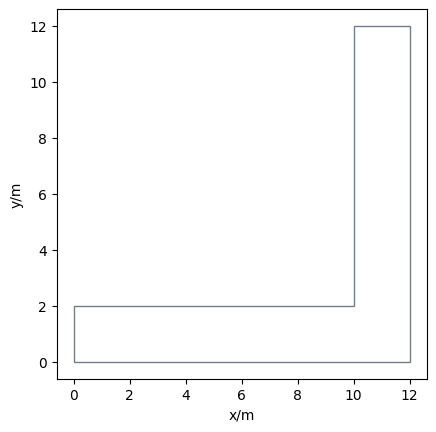

In [4]:
area = Polygon([(0, 0), (12, 0), (12, 12), (10, 12), (10, 2), (0, 2)])
walkable_area = pedpy.WalkableArea(area)
pedpy.plot_walkable_area(walkable_area=walkable_area).set_aspect("equal")

## Definition of Start Positions and Exit

In [14]:
spawning_area = Polygon([(0, 0), (6, 0), (6, 2), (0, 2)]) # the area where the agent will spawn
num_agents = 20 # number of agents
pos_in_spawning_area = jps.distributions.distribute_by_number(
    polygon=spawning_area,
    number_of_agents=num_agents,
    distance_to_agents=0.4, # min distance between agents
    distance_to_polygon=0.2, # distante to polygon border
    seed=1, # to specify which ramdom sequence we whant
)

exit_area = Polygon([(10, 11), (12, 11), (12, 12), (10, 12)]) # exit area

In [15]:
def plot_simulation_configuration(
    walkable_area, spawning_area, starting_positions, exit_area
):
    axes = pedpy.plot_walkable_area(walkable_area=walkable_area) # to create walkable area
    axes.fill(*spawning_area.exterior.xy, color="lightgrey") # to paint spawning area
    axes.fill(*exit_area.exterior.xy, color="indianred") # to paint exit area
    axes.scatter(*zip(*starting_positions)) # agents positions
    axes.set_xlabel("x/m")
    axes.set_ylabel("y/m")
    axes.set_aspect("equal")

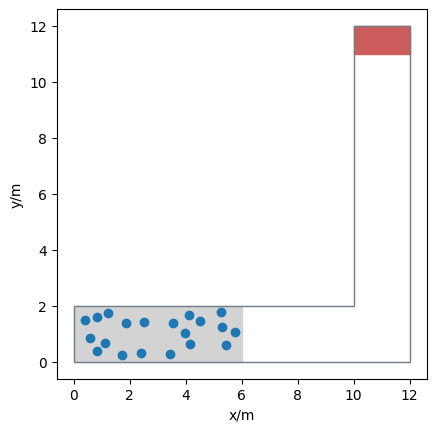

In [16]:
plot_simulation_configuration(
    walkable_area, spawning_area, pos_in_spawning_area, exit_area
)

## Setting up the Simulation and Routing Details

In [27]:
trajectory_file = "../../sqlite_data/corner.sqlite"  # output file
simulation = jps.Simulation(
    model=jps.CollisionFreeSpeedModel(),
    geometry=area,
    trajectory_writer=jps.SqliteTrajectoryWriter(
        output_file=pathlib.Path(trajectory_file)
    ),
)

In [28]:
exit_id = simulation.add_exit_stage(exit_area.exterior.coords[:-1]) # take al coords except the last one
journey = jps.JourneyDescription([exit_id])
journey_id = simulation.add_journey(journey)

## Agent Parameters and Executing the Simulation

In [29]:
v_distribution = normal(1.34, 0.05, num_agents) # normal distribution is used to asign each agents movement speed

for pos, v0 in zip(pos_in_spawning_area, v_distribution): # zip combines both lists
    simulation.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            journey_id=journey_id, stage_id=exit_id, position=pos, v0=v0
        )
    )

while simulation.agent_count() > 0:
    simulation.iterate()

## Visualizing the Trajectories

In [44]:
trajectory_data, walkable_area = read_sqlite_file(trajectory_file)
animate(trajectory_data, walkable_area, every_nth_frame=5)

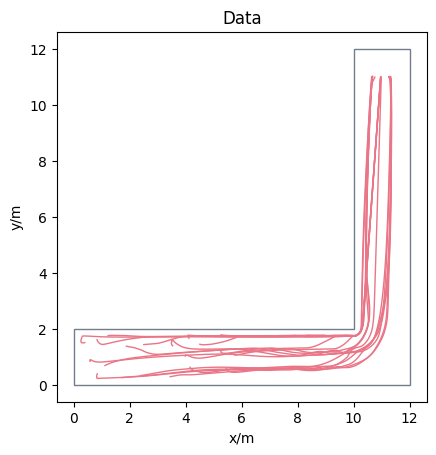

In [34]:


cfsm_data, walkable_area = read_sqlite_file(trajectory_file)

fig = plt.figure() # new figure to containg the graphs


ax1 = fig.add_subplot(111, aspect="equal") # 111 -> 1 line, 1 columns and position 1 | aspect="equal" -> same X, Y axis
ax1.set_title("Data")
pedpy.plot_trajectories(
    traj=cfsm_data,
    axes=ax1,
    walkable_area=walkable_area,
)

plt.show()

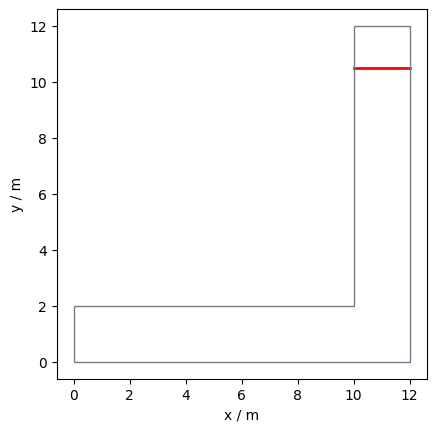

In [39]:
measurement_line = pedpy.MeasurementLine([(10, 10.5), (12, 10.5)]) # it has to be before the objective
pedpy.plot_measurement_setup(
    walkable_area=walkable_area,
    measurement_lines=[measurement_line],
    ml_color="red",
    ml_width=2,
).set_aspect("equal")
plt.show()

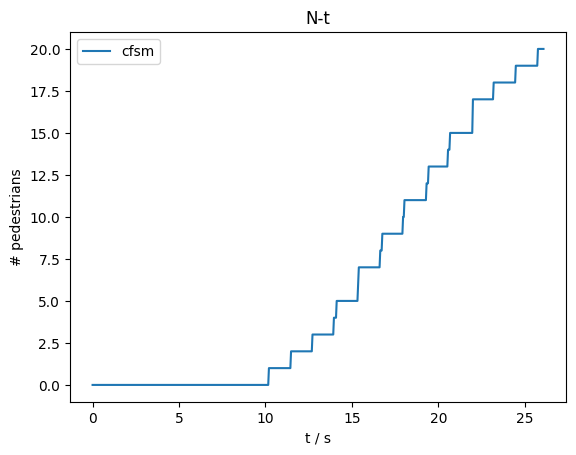

In [41]:
nt_cfsm, _ = pedpy.compute_n_t(
    traj_data=cfsm_data,
    measurement_line=measurement_line,
)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("N-t")
ax.plot(nt_cfsm["time"], nt_cfsm["cumulative_pedestrians"], label="cfsm")
ax.legend()
ax.set_xlabel("t / s")
ax.set_ylabel("# pedestrians")
plt.show()